# Using SimilaritySearch.jl to search Wiktionary (more than 1M english words under the Levenshtein distance)

This example shows how to create an index and solve queries using the Levenshtein distance using our `SearchGraph` index. Here we also show a UMAP visualization (click the button to compute it), with several parameters. Please feel free to probe everything, but be careful since Levenshtein distance could be quite expensive. 

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 


```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```


Note 1: There is no too much information of Levenshtein distance visualizations in the literature, it would be interesting to mine the latent clusters.

Note 2: The projections take some time in my 32-cores system (approx. 5 min, plust the the indexing that takes aprox. 1 min with data loading, using 32 threads using 32 threads), so think about this before running this notebook.

_june 1st, 2023: working with `SimilaritySearch` v0.10 and `TextSearch` v0.16. I also changed from `Plots` to `Makie`._

In [1]:
using Pkg
Pkg.activate(".")
if !isfile("Manifest.toml")
    Pkg.add([
        PackageSpec(name="SimilaritySearch", version="0.10"),
        PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
        PackageSpec(name="Strs"),
        PackageSpec(name="DataFrames"),
        PackageSpec(name="CairoMakie"),
        PackageSpec(name="ColorSchemes"),
        PackageSpec(name="Colors"),
        PackageSpec(name="JLD2"),
        PackageSpec(name="HypertextLiteral"),
        PackageSpec(name="DataFrames"),
        PackageSpec(name="CSV"),
    ])
end

using SimilaritySearch, SimSearchManifoldLearning, CairoMakie, ColorSchemes, Colors
using LinearAlgebra, HypertextLiteral, Strs, DataFrames, JLD2
using DataFrames, CSV
using Downloads: download


  Activating project at `~/Research/SimilaritySearchDemos/wiktionary`


In [2]:
indexfile = "enwiktionary-index.jld2"
umapfile = "enwiktionary-umap-embeddings.jld2"
res = KnnResult(10)
DB = CSV.read("enwiktionary.csv.gz", DataFrame)

function create_index(db)
    dist = LevenshteinDistance()
    G = SearchGraph(; db, dist, verbose=false)
    index!(G; parallel_block=512)
    optimize!(G, MinRecall(0.8))
    G
end


create_index (generic function with 1 method)

In [3]:
@time idx = let
    db = VectorDatabase(UTF32Str.(DB.word))
    create_index(db)
end

Threads.nthreads()

 52.433630 seconds (14.07 M allocations: 884.131 MiB, 0.74% gc time, 10.71% compilation time)


32

In [4]:
function search_and_display(idx, query, res, k=10)
	res = reuse!(res, k)
	@time search(idx, query, res)
	L = []
	for (i, p) in enumerate(res)
		word = database(idx, p.id)
		push!(L, @htl """
		<tr><td>$i</td><td>$(word)</td><td>$(p.id)</td><td>$(round(p.weight, digits=3)) </td><td><a href="https://en.wiktionary.org/wiki/$(word)" target="_blank">meaning</a></td></tr>
		""")
	end
	
	@htl """

<h2>Query "$(query)", n=$(length(idx))</h2>
<table>
<tr><td>knn</td><td>word</td><td>id</td><td>dist</td><td>wiktionary</td></tr>
$L
</table>

	"""
end


search_and_display (generic function with 2 methods)

# Random queries

In [5]:
n = length(idx)

for i in 1:5
    q = idx[rand(1:n)]
    search_and_display(idx, q, res) |> display
end

  0.013869 seconds (5 allocations: 21.812 KiB)


knn,word,id,dist,wiktionary
1,osteolathyrism,501289,0.0,meaning
2,neurolathyrism,229595,4.0,meaning
3,angiolathyrism,776789,4.0,meaning
4,osteopathist,585151,4.0,meaning
5,lathyrism,229596,5.0,meaning
6,osteopathy,28287,5.0,meaning
7,osteolysis,330185,5.0,meaning
8,osteopsathyrosis,593427,5.0,meaning
9,osteoadherin,721567,5.0,meaning
10,osteopathic,103278,5.0,meaning


  0.013203 seconds (5 allocations: 21.812 KiB)


knn,word,id,dist,wiktionary
1,blanket loans,317576,0.0,meaning
2,blanket loan,28060,1.0,meaning
3,blanket liens,280460,2.0,meaning
4,blanket-coats,943075,3.0,meaning
5,blanketcoats,943077,3.0,meaning
6,blanket lien,280459,3.0,meaning
7,blanket terms,286535,4.0,meaning
8,blanket baths,811616,4.0,meaning
9,blanket bath,811615,4.0,meaning
10,blanket-coat,943074,4.0,meaning


  0.002964 seconds (4 allocations: 7.375 KiB)


knn,word,id,dist,wiktionary
1,foldboat,209847,0.0,meaning
2,fold boat,209849,1.0,meaning
3,folboat,209848,1.0,meaning
4,foldboats,217190,1.0,meaning
5,folkboat,911309,1.0,meaning
6,foldout,138454,2.0,meaning
7,fold-out,673272,2.0,meaning
8,fold boats,217193,2.0,meaning
9,folbot,209850,2.0,meaning
10,folboats,217191,2.0,meaning


  0.003793 seconds (4 allocations: 7.375 KiB)


knn,word,id,dist,wiktionary
1,oligomerases,951011,0.0,meaning
2,oligomerises,613342,1.0,meaning
3,oligomerase,951010,1.0,meaning
4,oligomerizes,155412,2.0,meaning
5,oligomerise,613340,2.0,meaning
6,oligomerised,613341,2.0,meaning
7,isomerases,180715,3.0,meaning
8,oligomers,127948,3.0,meaning
9,oligornases,859834,3.0,meaning
10,oligomerize,136333,3.0,meaning


  0.003208 seconds (4 allocations: 7.375 KiB)


knn,word,id,dist,wiktionary
1,coalifications,604356,0.0,meaning
2,coalification,200289,1.0,meaning
3,codifications,160591,2.0,meaning
4,cornifications,169649,2.0,meaning
5,qualifications,49049,2.0,meaning
6,clarifications,98315,2.0,meaning
7,mollifications,156803,2.0,meaning
8,calcifications,241543,2.0,meaning
9,chylifications,688507,2.0,meaning
10,jollifications,279525,2.0,meaning


# Direct queries

In [6]:
search_and_display(idx, UTF32Str("jam"), res) |> display
search_and_display(idx, UTF32Str("bartman"), res) |> display
search_and_display(idx, UTF32Str("mississippi"), res) |> display
search_and_display(idx, UTF32Str(""), res) |> display

  0.001939 seconds (4 allocations: 7.375 KiB)


knn,word,id,dist,wiktionary
1,jam,9699,0.0,meaning
2,aam,96,1.0,meaning
3,lam,3164,1.0,meaning
4,pam,3173,1.0,meaning
5,ram,4348,1.0,meaning
6,jay,4257,1.0,meaning
7,ham,5559,1.0,meaning
8,jag,5561,1.0,meaning
9,yam,8629,1.0,meaning
10,jaw,8571,1.0,meaning


  0.004310 seconds (4 allocations: 7.375 KiB)


knn,word,id,dist,wiktionary
1,Hartman,115634,1.0,meaning
2,Cartman,322388,1.0,meaning
3,cartman,379354,1.0,meaning
4,Gartman,747672,1.0,meaning
5,Bartman,754948,1.0,meaning
6,Zartman,760613,1.0,meaning
7,batman,9180,1.0,meaning
8,barman,69636,1.0,meaning
9,Martian,22434,2.0,meaning
10,martian,40291,2.0,meaning


  0.011493 seconds (5 allocations: 21.812 KiB)


knn,word,id,dist,wiktionary
1,Mississippi,24272,1.0,meaning
2,Mississippis,644592,2.0,meaning
3,Mississippian,35637,3.0,meaning
4,Mississippians,217773,4.0,meaning
5,missionise,302210,5.0,meaning
6,missionised,302213,5.0,meaning
7,missioning,197651,5.0,meaning
8,missionises,302211,5.0,meaning
9,missitting,430995,5.0,meaning
10,mislisting,436225,5.0,meaning


  0.002991 seconds (5 allocations: 21.812 KiB)


knn,word,id,dist,wiktionary
1,℅,14900,1.0,meaning
2,♨,169808,1.0,meaning
3,℀,247697,1.0,meaning
4,℻,247698,1.0,meaning
5,℁,291745,1.0,meaning
6,℞,304036,1.0,meaning
7,℟,330697,1.0,meaning
8,pi,1800,2.0,meaning
9,si,6101,2.0,meaning
10,mi,1232,2.0,meaning


# Visualization

## Functions to create low dimensional projections

In [7]:
function umap_embeddings(index, db; k=10, n_epochs=100, neg_sample_rate=5, tol=1e-3, layout=SpectralLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol) 
    @time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    #jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    if length(index) == length(db)
        e2 = predict(U2)
        e3 = predict(U3)
    else
        @time e2 = clamp.(predict(U2, db), -10f0, 10f0)
        @time e3 = clamp.(predict(U3, db), -10f0, 10f0)
    end
    (; e2, e3)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

normcolors (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. More even because this example uses SpectralLayout since the number of elements allow it. Note that we are creating 2d and 3d projections

In [8]:
uindex = let 
    V = database(idx)
    db = VectorDatabase(V.vecs[rand(1:length(V), 10000)])
    create_index(db)
end

SearchGraph{GenericLevenshteinDistance, VectorDatabase{Vector{UTF32Str}}, SimilaritySearch.AdjacencyLists.AdjacencyList{UInt32}, BeamSearch}
  dist: GenericLevenshteinDistance
  db: VectorDatabase{Vector{UTF32Str}}
  adj: SimilaritySearch.AdjacencyLists.AdjacencyList{UInt32}
  hints: Array{Int32}((89,)) Int32[51, 109, 135, 154, 360, 396, 404, 424, 469, 528  …  2626, 2627, 2664, 2699, 2701, 2718, 2745, 2748, 2782, 2801]
  search_algo: BeamSearch
  len: Base.RefValue{Int64}
  verbose: Bool false


In [9]:
@time e2, e3 = umap_embeddings(uindex, database(idx));

  1.736162 seconds (36.60 k allocations: 303.249 MiB)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


  5.499265 seconds (2.14 M allocations: 1.943 GiB, 2.19% gc time, 43.72% compilation time)


UMAP construction time cost report:
- fuzzy graph: 0.155862071
- embedding init: 2.53375547
- embedding opt: 0.663901055



  0.613376 seconds (64 allocations: 281.531 KiB)
232.490676 seconds (5.44 M allocations: 36.747 GiB, 0.06% gc time, 0.17% compilation time)
226.053929 seconds (5.12 M allocations: 36.738 GiB, 1.84% gc time)
474.567986 seconds (26.43 M allocations: 76.319 GiB, 1.02% gc time, 2.68% compilation time)


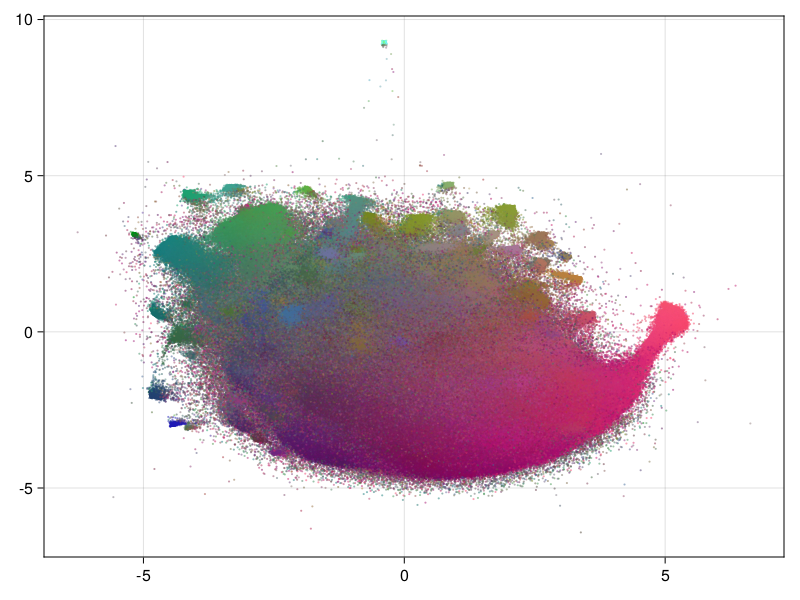

In [10]:
function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGBAf(c[1], c[2], c[3], 0.5) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    scatter(X, Y, color=C, markersize=3)
end

#=f = Figure(resolution = (800, 800))
ax = Axis(f[1,1], title = "Emoji's visualization", aspect = DataAspect())
hexbin!(ax, (@view e2[1, :]), (@view e2[2, :]); bins=200)
plot_umap(ax, e2, e3)
f
=#

plot_umap(e2, e3)

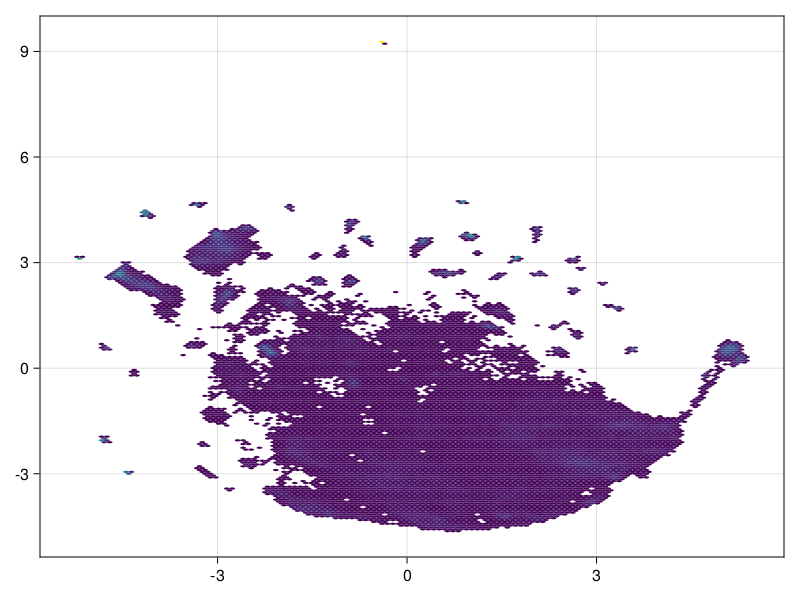

In [11]:
hexbin((@view e2[1, :]), (@view e2[2, :]); bins=300, threshold=60)

# Final notes

This example shows how to index, query, and visualize the wiktionary dataset under the Levenshtein distance. The visualization is made with UMAP low-dimensional projections. 

Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [12]:
Pkg.status()

Status `~/Research/SimilaritySearchDemos/wiktionary/Project.toml`
  [336ed68f] CSV v0.10.10
  [13f3f980] CairoMakie v0.10.5
  [35d6a980] ColorSchemes v3.21.0
  [5ae59095] Colors v0.12.10
  [a93c6f00] DataFrames v1.5.0
  [ac1192a8] HypertextLiteral v0.9.4
  [033835bb] JLD2 v0.4.31
  [91a5bcdd] Plots v1.38.15
  [ca7ab67e] SimSearchManifoldLearning v0.2.9
  [053f045d] SimilaritySearch v0.10.8
  [7bddbee9] Strs v1.1.0
